# Predict ADs on new TFs
Cleaned up 20210502 and 20210503 
Max Staller
mstaller@berkeley.edu

- "makeTilingDF" part takes the input TF list, chops into 39 AA 'tiles' spaced every 1 AA.
- It also computes some parameters on each 39 AA tile.
- In parrallel, "makeFullLengthProteinDF" builds a DataFrame of full length TFs. It uses this later to combine overlapping tiles

- Next, "ThresholdProteome_withaLine" identifies the 'tiles' that balance acidic and hydrophobic resiudes similarly to VP16 and CITED2. This is the section that plan to improve in summer 2021. 

- "maskproteome" is the helper function that runs "ThresholdProteome_withaLine." It is left over from when we were trying different iterations/modifications of the predictor. 
- Finally, "AggregateTilesIntoPredictedADs" combines the tiles into predicted ADs. Note it has on occasion messed up but I think it is fixed now. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import os
import operator


import matplotlib
import pickle
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# Master control variables (input and output files)

In [2]:
########
# Fasta File with proteins to scan for activation domains
inputfilename = 'SupportFiles/test.fasta'
# inputfilename = 'SupportFiles/ncGRN_protfasta.txt'
# inputfilename = 'SupportFiles/LambertTFs.fasta' # all human TFs THIS IS SLOW TO RUN

# File to save output predicted AD sequences
exportfilename = 'output_predicted_activation_domains.csv'



### make the output folder
if (os.path.isdir('Output/')):
    print 'Figures folder exists'
else:
    os.mkdir('Output')

Figures folder exists


# Functions


In [3]:
# extract 39 AA windows from all TFs in a FASTA file
def makeTilingDF(inputfilename,WindowSize = 39, WindowSpacing = 1,AAs = ['W','F','Y','M','L','Q']):
    #open file
    myfile  = open(inputfilename,'r')
    Orthologs = myfile.readlines()
    myfile.close()
    
    TilingWindows,ProteinNames,IUpredScores,Npos,Cpos = [],[],[],[],[]

    for line in Orthologs:
        if line[0] == ">": # focus on protein sequences
            name = line.strip()#.split('|')[2]
        else: # focus on protein sequences
            line =line.strip()
            line =line.upper()
            # take tilingwindows
            if len(line)<WindowSize:
                subset = line
                Npos.append(0),Cpos.append(len(line))
                #print subset
                TilingWindows.append(subset)
                ProteinNames.append(name)
                IUpredScores.append(np.mean(IUpredVector))
            else:
                for i in xrange(0,len(line)-WindowSize+WindowSpacing,WindowSpacing):
                    subset = line[i:i+WindowSize]
                    Npos.append(i),Cpos.append(i+WindowSize)
                    #print subset
                    TilingWindows.append(subset)
                    ProteinNames.append(name)
    print "Window Size = %i  and Window spacing = %i" % (WindowSize, WindowSpacing)
    print "Number of Tiling Windows: %i" %len(TilingWindows)

    ProteomeDF = pd.DataFrame({'ProteinWindowSeq':TilingWindows,'GeneName':ProteinNames,
                              'StartPosition':Npos,'EndPosition':Cpos})
    ## add #count important AAs
    for aa in AAs:
        ProteomeDF[aa]= ProteomeDF.apply(lambda row: row['ProteinWindowSeq'].count(aa),axis=1)
    #compute net charge
    ProteomeDF['Charge'] = ProteomeDF.apply(lambda row: row['ProteinWindowSeq'].count('K')+row['ProteinWindowSeq'].count('R')-row['ProteinWindowSeq'].count('D')-row['ProteinWindowSeq'].count('E'),axis=1)
                                        
    return ProteomeDF

# also make a DF with full length protein sequences
def makeFullLengthProteinDF(inputfilename):
    #open file
    myfile  = open(inputfilename,'r')
    ProteinList = myfile.readlines()
    myfile.close()
    
    ProteinSeqs,ProteinNames = [],[]
    for line in ProteinList:
        if line[0] == ">": # focus on protein sequences
            name = line.strip()#.split('|')[2]
        else: # focus on protein sequences
            line =line.strip()
            line =line.upper()
            ProteinSeqs.append(line)
            ProteinNames.append(name)
    ProteomeDF = pd.DataFrame({'GeneName':ProteinNames,'AAseq':ProteinSeqs})
    print 'There are %i proteins'%len(ProteinSeqs)
    return ProteomeDF


In [14]:
# read in the Lambert TF seqs and make a DF with tilting windows
Sequences_to_Test = makeTilingDF(inputfilename,WindowSize = 39, WindowSpacing = 1,AAs = ['W','F','Y','L'])

## Build a DF with all the full length TF seqs
FullLengthProteinsTested = makeFullLengthProteinDF(inputfilename)


### load precomputed support variables
# load in the background human TF distribution
Counts = pickle.load(open('SupportFiles/HumanTFTiles_Counts','r')) # for 2D heatmap

Counts_df = pd.DataFrame(Counts)
Counts_df.to_csv('SupportFiles/HumanTFTiles_Counts_v2.csv')
Counts.shape

Window Size = 39  and Window spacing = 1
Number of Tiling Windows: 2471
There are 6 proteins


(60, 20)

# Predict ADs with a line

In [5]:
# THIS IS MAIN PREDICTION FUNCTION.
def ThresholdProteome_withaLine(ProteomeDF,Line,LowerCorner,UpperCorner,AAs = ['W','F','Y','L'],propset =['Charge','AllHydros']):
    fig = plt.figure(figsize=(8,3))
    # combine all the hydrophobic residues of interest
    AllHydros = ProteomeDF[AAs].sum(axis=1)
    ProteomeDF['AllHydros'] = AllHydros
    

    # plot the background distribution--all human TFs--as a heatmap
    # TO DO replace this with heatmap plotting to make it look better
    if (propset[0]=='Charge')&(propset[1]=='AllHydros'):
        overlayPredictionsOverAllTiles_v2(propset)
#     else:
#         plt.scatter(BackgroundDF.propset[0],BackgroundDF.propset[1],marker='.',c='gray',label='All Regions')

    SLOPE =1
    # for each tile, calculate value
    LineValue = SLOPE*(ProteomeDF.Charge-Line[0])-(ProteomeDF.AllHydros-Line[1])
    # theshold
    LowerCornerSet = (ProteomeDF.Charge<=LowerCorner[0])&(ProteomeDF.AllHydros>=LowerCorner[1]) #& ProteomeDF.IDR
    UpperCornerSet = (ProteomeDF.Charge<=UpperCorner[0])&(ProteomeDF.AllHydros>=UpperCorner[1]) #& ProteomeDF.IDR
    BothSet = (LineValue<=0)  &  (ProteomeDF.Charge<=UpperCorner[0]) &(ProteomeDF.AllHydros>=LowerCorner[1]) #& (ProteomeDF.IDR)

    plt.scatter(ProteomeDF[BothSet].Charge,ProteomeDF[BothSet].AllHydros,label='Above the line N = %s'%sum(BothSet))
    plt.scatter([LowerCorner[0],UpperCorner[0]],[LowerCorner[1],UpperCorner[1]],c='r')
    plt.ylabel('Number of '+','.join(AAs)), plt.xlabel('Charge'),plt.legend()
    plt.show()

    return BothSet
# ------------------------------------------------------------------------------------------

colormap,dotcolor = 'Greys','w'
ADcolorDict2 ={'CITED2_N':'*', 'vp16N_C':'x'}
def overlayPredictionsOverAllTiles_v2(propset =['Charge','AllHydros'],flip=False):
    Prop1Span = np.arange(-39,21,1)# hard coded to match shape of precomputed heatmap
    Prop2Span = np.arange(0,20,1) # hard coded to match shape of precomputed heatmap
    Prop1SpanMesh, Prop2SpanMesh = np.meshgrid(Prop1Span,Prop2Span)
    ## Human TFs 
    Z =np.log10(Counts.transpose())     
    if flip:
        Y,X= Prop1SpanMesh, Prop2SpanMesh,
    else:
        X,Y= Prop1SpanMesh, Prop2SpanMesh,
    cs  = plt.scatter(X,Y, c=Z,cmap=colormap, alpha=1,label='All Human TF regions',marker='s',s=21,linewidths=0)
    # Add a color bar which maps values to colors.
    plt.colorbar(cs, shrink=1, aspect=20,label='log10(Abundance)',ticks=[0,1,2,3,4],drawedges=False)
# ------------------------------------------------------------------------------------------

# This is the helper function that runs prediction function. 
AAlist = ['W','F','Y','L']
def maskproteome(lineparameters=[[-13,7],[-13,7],[-9,10]],AAs = AAlist):
    TEMPindx = ThresholdProteome_withaLine(Sequences_to_Test,lineparameters[0],lineparameters[1],lineparameters[2],AAs)

    MaskedProteomeDF = Sequences_to_Test[TEMPindx]
    print 'There are %i regions of length %i AA as extreme or more than this AD'%(len(MaskedProteomeDF),len(MaskedProteomeDF.ProteinWindowSeq.values[0]))
    print 'These regions come from %i proteins' % len(set(MaskedProteomeDF.GeneName))

    ## aggregate the regions
    for gene in set(MaskedProteomeDF.GeneName):
        indx = MaskedProteomeDF.GeneName == gene
        tempDF = MaskedProteomeDF[indx]
        start, end = min(tempDF.StartPosition),max(tempDF.EndPosition)
        print '%s \t%i AA \tfrom %i - %i'%(gene,end-start+1,start,end)
    return TEMPindx
# ------------------------------------------------------------------------------------------

# Function to combine the Predicted Tiles into predicted ADs--look for overlapping tiles
def AggregateTilesIntoPredictedADs(Sequences_to_Test_DF,TEMPindx,exportfilename):

    CombinedPredictions = Sequences_to_Test_DF[TEMPindx]

    genenames, starts,ends, seqs,regionlengths,RegionType = [],[],[],[],[],[]
    for gene in set(CombinedPredictions.GeneName):
        indx = CombinedPredictions.GeneName == gene
        tempDF = CombinedPredictions[indx]
        tempDF = tempDF.reset_index()
        start, end = min(tempDF.StartPosition)+1,max(tempDF.EndPosition)
        # test if there are missing tiles or multiple regions
        if (((max(tempDF.StartPosition)-min(tempDF.StartPosition))-(sum(indx)))>39): #check if tiles overlap
            # tiles DO NOT overlap, use hand called regions
            previousstart,previousend = tempDF.StartPosition[0],tempDF.EndPosition[0]
            for i, entry in tempDF.iterrows():
                if entry.StartPosition < previousend+39:
                    previousend = entry.EndPosition
                else:
                    starts.append(previousstart)
                    ends.append(previousend)
                    regionlengths.append(previousend-previousstart)
                    genenames.append(gene)
                    RegionType.append('Prediction')
                    previousstart,previousend = entry.StartPosition,entry.EndPosition
            # add last predicted region
            starts.append(previousstart)
            ends.append(entry.EndPosition)
            regionlengths.append(entry.EndPosition-previousstart)
            genenames.append(gene)
            RegionType.append('Prediction')
            if 0==1: # debugging
                print(gene +' had more than one region')
                print tempDF[['GeneName','StartPosition','EndPosition']]
        else:
            starts.append(start)
            ends.append(end)
            regionlengths.append(end-start)
            genenames.append(gene)
            RegionType.append('Prediction')
    print "\n---\nThere are %i predicted candidate AD regions on %i TFs" %(len(starts),len(set(genenames)))
    # make a DF with geneNames and start and End positions of the overlapping windows
    CandidateADsToTest = pd.DataFrame({'GeneName':genenames,'Start':starts,'End':ends,'Length':regionlengths,'RegionType':RegionType})

    #add a column for full length AA seq
    tempDict = dict(zip(FullLengthProteinsTested.GeneName,FullLengthProteinsTested.AAseq))
    tempSeries = CandidateADsToTest.GeneName
    CandidateADsToTest['FullProteinSeq'] = tempSeries.map(tempDict)


    ## pull out regions of these TFs
    # CandidateADsToTest['Region2Test'] = CandidateADsToTest.apply(lambda row: row.FullProteinSeq[row.Start:row.End], axis=1)
    #correct for counting starting at 0 in python and 1 in real world
    ProteinRegionSeqs =[]
    for i, row in CandidateADsToTest.iterrows():
        start =row.Start
        end = row.End
        Region = row.FullProteinSeq[start:end]
        ProteinRegionSeqs.append(Region)
    CandidateADsToTest['ProteinRegionSeq']=ProteinRegionSeqs
    CandidateADsToTest = CandidateADsToTest.drop(['FullProteinSeq'], axis=1)

    CandidateADsToTest.to_csv('Output/'+exportfilename)

    return CandidateADsToTest


# Predict Activation Domains
These regions balance at least 7 aromatic and leucine residues with a net charge of at least -9. For now, they interpolate a line between VP16 and CITED2.

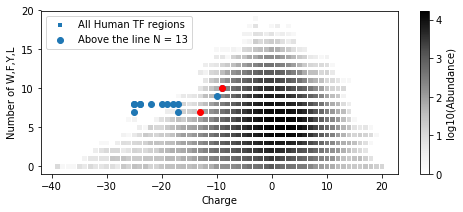

There are 13 regions of length 39 AA as extreme or more than this AD
These regions come from 2 proteins
>sp|P04150|GCR_HUMAN 	48 AA 	from 206 - 253
>sp|Q96QS3|ARX_HUMAN 	50 AA 	from 220 - 269

---
There are 2 predicted candidate AD regions on 2 TFs


,End,GeneName,Length,RegionType,Start,ProteinRegionSeq
0,253,>sp|P04150|GCR_HUMAN,46,Prediction,207,TNESPWRSDLLIDENCLLSPLAGEDDSFLLEGNSNEDCKPLILPDT
1,269,>sp|Q96QS3|ARX_HUMAN,48,Prediction,221,GTEDDEEELLEDEEDEDEEEELLEDDEEELLEDDARALLKEPRRCPVA


In [7]:
# ------------------------------------------------------------------------------------------
# This is the main prediction function. 
PredictedTiles = maskproteome(lineparameters=[[-9,10],[-13,7],[-9,10]])
#[-9,10] is CITED2
#[-13,7] is VP16
AggregateTilesIntoPredictedADs(Sequences_to_Test,PredictedTiles,exportfilename)
# ------------------------------------------------------------------------------------------